In [ ]:
import numpy as np
import pandas as pd
import pickle

from PIL import Image
import os
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
import networkx as nx
import random
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist


In [ ]:
EMBEDDING_DIM = 4

# Functions

In [3]:
def knn_graph(matrix, k=5):
    G = nx.Graph()
    nbrs = NearestNeighbors(n_neighbors=k).fit(matrix)
    distances, indices = nbrs.kneighbors(matrix)
    
    for i in range(len(matrix)):
        G.add_node(i, pos=(matrix[i, 0], matrix[i, 1]))
        for j in indices[i]:
            if i != j:
                G.add_edge(i, j, weight=distances[i][np.where(indices[i] == j)[0][0]])
    
    return G

def plot_knn_graph(G,highlighted_nodes,polygon_mask):
    
    # Create a color map for nodes
    highlight_color = "#FF4500"
    node_colors = [highlight_color if node in highlighted_nodes else 'lightblue' for node in G.nodes()]
    #if pos == None:    
    pos = nx.get_node_attributes(G, 'pos')
    # Draw the graph
    fig,ax = plt.subplots(figsize=(8, 8))
    ax.imshow(polygon_mask, cmap='gray', alpha=0.3)
    nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.6,ax = ax)
    return fig,ax
    
def plot_scatter(pos,highlighted_nodes,polygon_mask):
    
    # Create a color map for nodes
    highlight_color = "#FF4500"
    node_colors = [highlight_color if i in highlighted_nodes else 'lightblue' for i in np.arange(1000)]
    #if pos == None:    
    #pos = nx.get_node_attributes(G, 'pos')
    # Draw the graph
    fig,ax = plt.subplots(figsize=(8, 8))
    ax.imshow(polygon_mask, cmap='gray', alpha=0.3)
    ax.scatter(pos[:,0],pos[:,1],s = 50,c = node_colors)
    #nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.6,ax = ax)
    return fig,ax


    #nx.draw(G, pos, with_labels=False, node_size=100, node_color='lightblue', edge_color='gray', alpha=0.6)
    #plt.show()

def plot_knn_graph_pos(G,highlighted_nodes,pos):
    #pos = nx.get_node_attributes(G, 'pos')
    highlight_color = "#FF4500"
    node_colors = [highlight_color if node in highlighted_nodes else 'lightblue' for node in G.nodes()]
    fig,ax = plt.subplots(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.6,ax = ax)
    return fig,ax
    
def compute_kernel_matrix(X,k):
    D = squareform(pdist(X))
    D_s = np.argsort(D,axis=1)
    sig = np.median(D_s[:,(k+1)])
    #K = np.exp(-D**2/np.outer(sig,sig))    
    K = np.exp(-D**2/sig**2)    
    return K

def compute_laplacian(K):
    D_inv = np.diag(np.sum(K,axis = 1)**(-0.5))
    L = D_inv@K@D_inv
    return L

def compute_leading_eigenvectors(L,d):
    lam,v = np.linalg.eigh(L)
    sort_idx = np.argsort(lam)[::-1]
    lam = lam[sort_idx]
    v = v[:,sort_idx]
    return lam[:d],v[:,:d]

    

In [4]:

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))  # Reduce size by half
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return image, hsv

def detect_shapes(image):
    polygon_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    rectangles = []
    circles = []
    
    # Define color ranges
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 50])
    blue_lower = np.array([100, 150, 50])
    blue_upper = np.array([140, 255, 255])
    green_lower = np.array([40, 50, 50])
    green_upper = np.array([90, 255, 255])
    
    # Detect black polygon
    black_mask = cv2.inRange(image, black_lower, black_upper)
    contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(polygon_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Detect blue rectangles
    blue_mask = cv2.inRange(image, blue_lower, blue_upper)
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rectangles.append((x, y, w, h))
    
    # Detect green circles
    green_mask = cv2.inRange(image, green_lower, green_upper)
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circles.append((int(x), int(y), int(radius)))
    
    return polygon_mask, rectangles, circles


def generate_random_points(mask, num_points=1000):
    points = []
    h, w = mask.shape
    while len(points) < num_points:
        x, y = random.randint(0, w-1), random.randint(0, h-1)
        if mask[y, x] == 255:
            points.append((x, y))
    return points

def build_graph(mask, rectangles):
    G = nx.grid_2d_graph(mask.shape[0], mask.shape[1])
    for x, y, w, h in rectangles:
        for i in range(x, x+w):
            for j in range(y, y+h):
                if (j, i) in G:                    
                    G.remove_node((j, i))
    return G

def compute_shortest_paths(G, points, circles):
    distance_matrix = np.zeros((len(points), len(circles)))
    for i, (px, py) in enumerate(points):
        if (i==10):
            print(i)
        for j, (cx, cy, _) in enumerate(circles):
            try:
                path_length = nx.shortest_path_length(G, (py, px), (cy, cx))
            except nx.NetworkXNoPath:
                path_length = float('inf')
            distance_matrix[i, j] = path_length
    return distance_matrix


# Ariel Example

In [ ]:
image_path = 'C:\\Users\\Noa\\Documents\\Thesis\\data\\floor_plan_c.png'

image, gray = load_image(image_path)
print(image.shape)
polygon_mask, rectangles, circles = detect_shapes(gray)
print('generating points')
random_points = generate_random_points(polygon_mask)

(129, 210, 3)
generating points


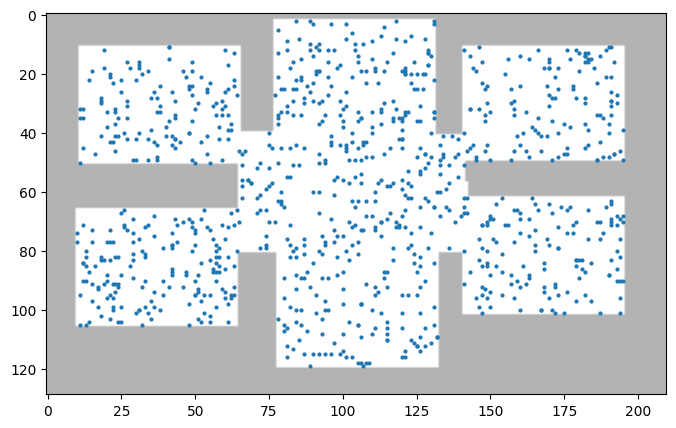

In [6]:
random_points = np.array(random_points)
fig,ax = plt.subplots(figsize=(8, 8))
ax.imshow(polygon_mask, cmap='gray', alpha=0.3)
ax.scatter(random_points[:,0],random_points[:,1],s = 4)
#print(random_points.shape)
    

In [7]:
G = build_graph(polygon_mask, rectangles)
distance_matrix = compute_shortest_paths(G, random_points, circles)

10


KeyboardInterrupt: 

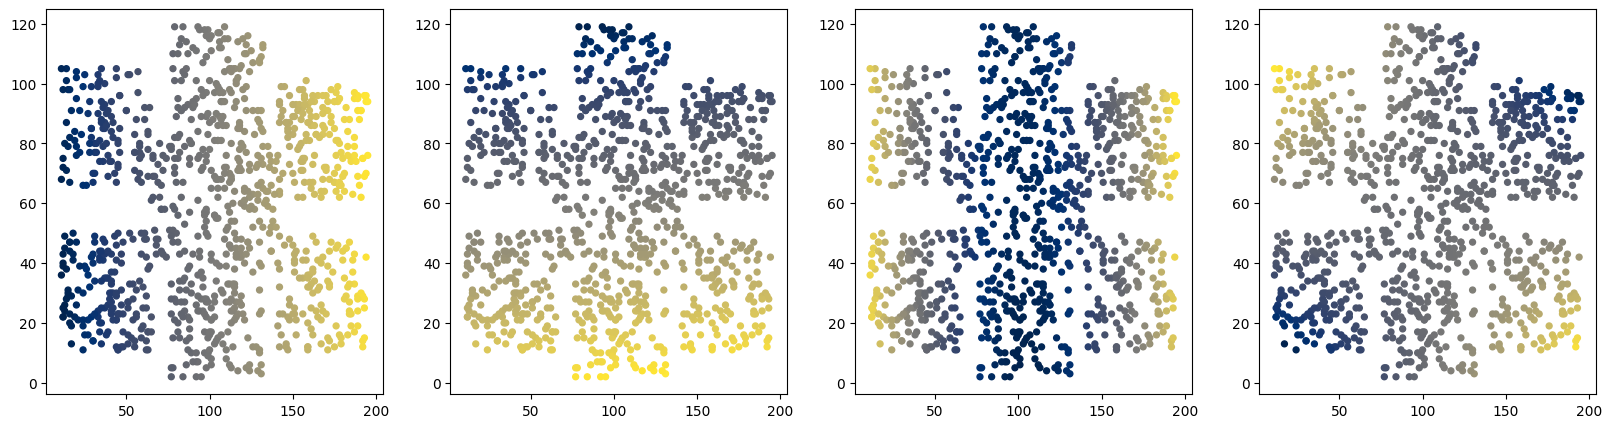

In [ ]:
K_p = compute_kernel_matrix(np.array(random_points),k = 7)
L_p = compute_laplacian(K_p)
#D_s = np.argsort(D,axis=1)
#    sig = D_s[:,(k+1)]
#    K = np.exp(-D**2/np.outer(sig,sig))
lam,v_p = compute_leading_eigenvectors(L_p,30)
fig,axs = plt.subplots(1,4,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points[:,0],random_points[:,1],c = v_p[:,i+1],s = 18,cmap = 'cividis')
fig.savefig('eigenvectors_location.png')


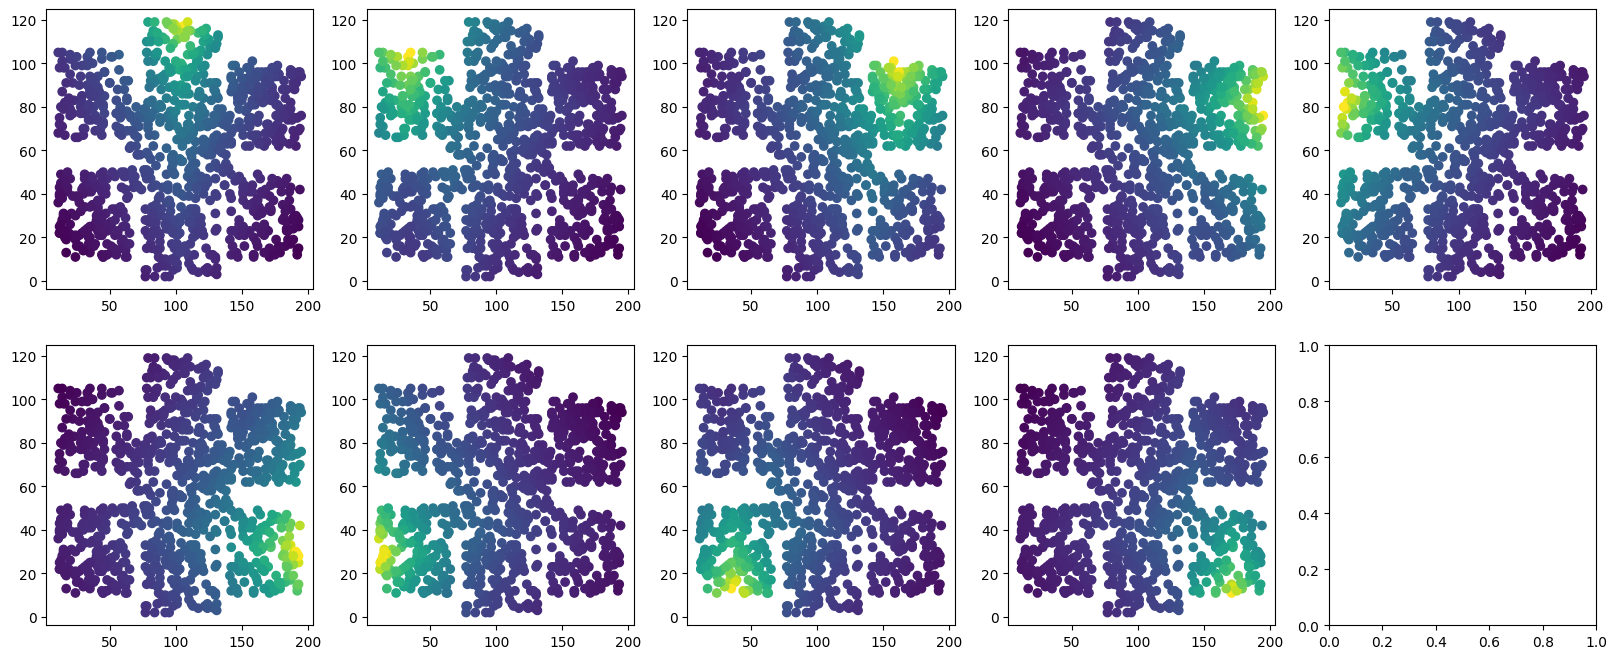

In [104]:
random_points = np.array(random_points)
fig,axs = plt.subplots(2,5,figsize = (20,8))
for i,ax in enumerate(axs.flatten()[:9]):
    ax.scatter(random_points[:,0],random_points[:,1],c = np.log(1/(distance_matrix[:,i]**2)))

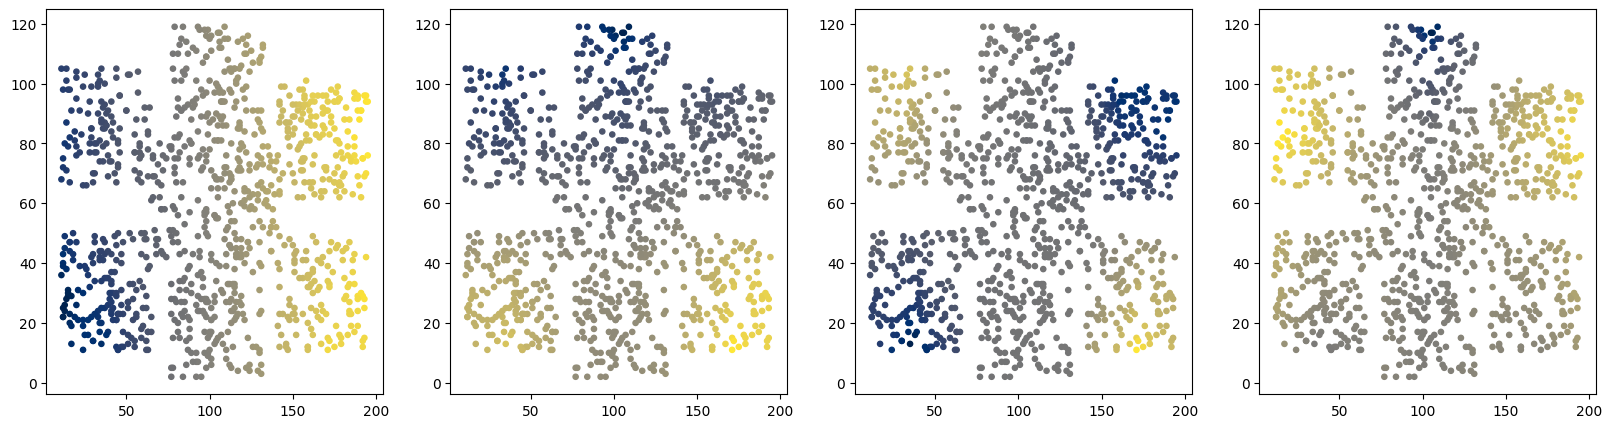

In [105]:
# signals 

K_sig = compute_kernel_matrix(np.log(1/(distance_matrix**2)),k = 7)
L_sig = compute_laplacian(K_sig)
#D_s = np.argsort(D,axis=1)
#    sig = D_s[:,(k+1)]
#    K = np.exp(-D**2/np.outer(sig,sig))
lam,v_sig = compute_leading_eigenvectors(L_sig,30) #Signals Embedding
fig,axs = plt.subplots(1,4,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points[:,0],random_points[:,1],c = v_sig[:,i+1],s = 14,cmap = 'cividis')
fig.savefig('eigenvectors_signals.png')

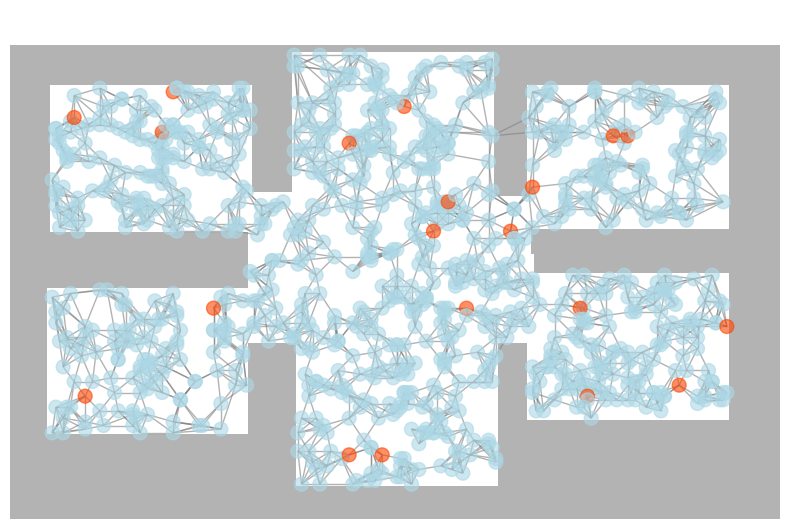

In [106]:
G_p = knn_graph(random_points,7)
highlighted = np.random.choice(np.arange(1000),size = 20,replace=False)
fig,ax = plot_knn_graph(G_p,highlighted,polygon_mask)
#ax.imshow(polygon_mask)
fig.tight_layout()
fig.savefig('graph_points.png')

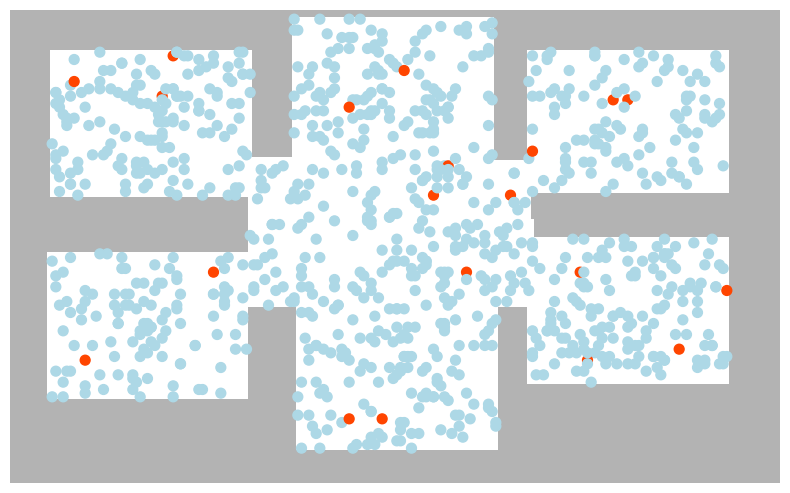

In [107]:
fig,ax = plot_scatter(random_points,highlighted,polygon_mask)
plt.axis('off')
fig.tight_layout()
fig.savefig('points_scatter.png')

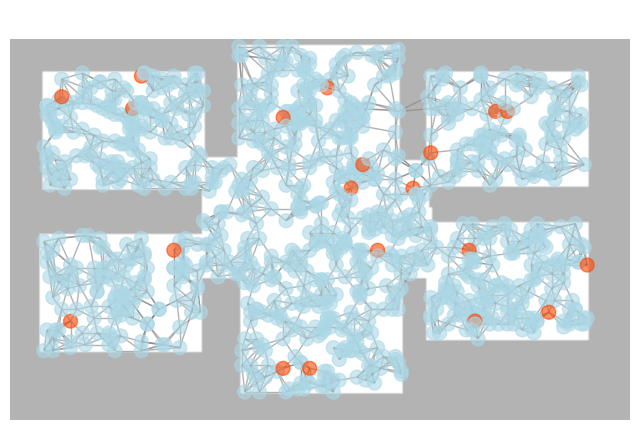

In [108]:
import matplotlib.colors as mcolors
fig,ax = plot_knn_graph(G_p,highlighted,polygon_mask)

#cmap = mcolors.ListedColormap([
#    (1, 1, 1, 1),    # White (Opaque)
#    (0.7, 0.7, 0.7, 0.3)  # Light Gray (50% Transparent)
#])
#bounds = [0, 0.5, 1]  # Define boundaries for 0 and 1
#norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize values

# Plot the binary image with imshow
#ax.imshow(polygon_mask, cmap=cmap, norm=norm)
#plt.axis('off')

In [109]:
polygon_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(129, 210), dtype=uint8)

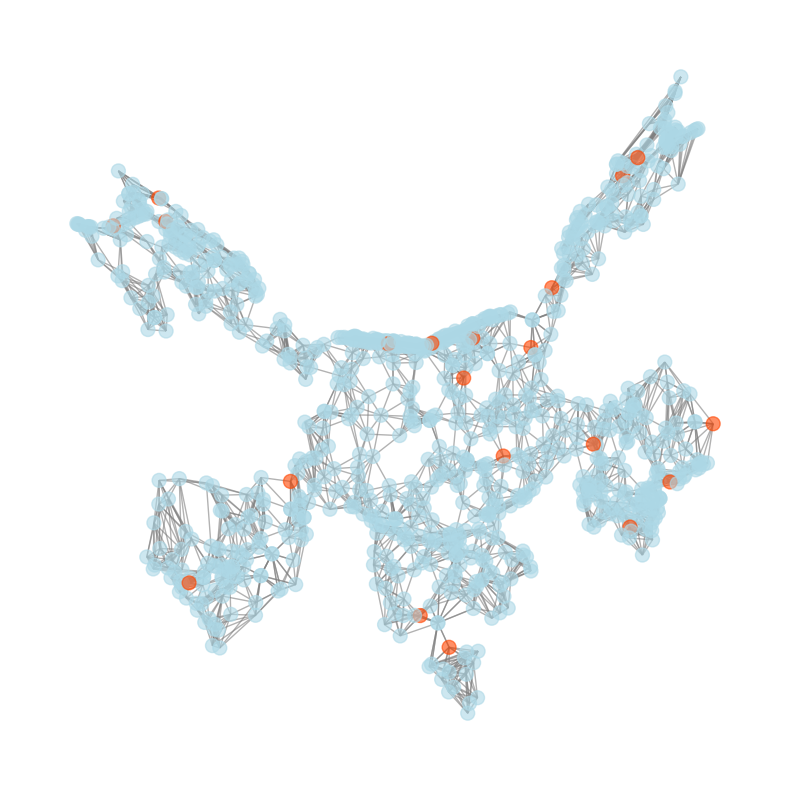

In [110]:
S = np.log(1/(distance_matrix**2))
G_sig = knn_graph(S,k = 10)
fig,ax = plot_knn_graph_pos(G_sig,highlighted,pos = v_sig[:,1:3])
#ax.plot(po)
fig.tight_layout()
fig.savefig('signals_graph.png')

# Robust example

In [42]:
class PhysicalLayoutGraph:
    def __init__(self, image_path, num_points=500, embedding_dim=EMBEDDING_DIM, k=7):
        self.image_path = image_path
        self.num_points = num_points
        self.embedding_dim = embedding_dim
        self.k = k
        self._process_image()
        self._center_layout()
        self._build_graph()
        self._compute_adjacency()
        self.embedding = None
        self.dist_matrix = None

    def _process_image(self):
        image, gray = load_image(self.image_path)
        self.image = image
        self.gray = gray
        self.polygon_mask, self.rectangles, self.circles = detect_shapes(gray)
        #self.df_points_with_signals = {'x': random_points_from_graph[:, 0], 'y': random_points_from_graph[:, 1]}

    def _center_layout(self):
        """Center only the random points."""
        h, w = self.polygon_mask.shape
        self.center_point = np.array([w // 2, h // 2])
        self.random_points = np.array(generate_random_points(self.polygon_mask, num_points=self.num_points))
        # self.A_mean = np.round(A_all.mean(axis=0, keepdims=True)).astype(int)
        # Center only the random points
        # self.random_points = A_all - self.A_mean
        
    def _build_graph(self):
        self.G = build_graph(self.polygon_mask, self.rectangles)
        # self.random_points = generate_random_points(self.polygon_mask, num_points=self.num_points)
        # A_all = np.array(self.random_points)
        # self.A_mean = np.round(A_all.mean(axis=0, keepdims=True)).astype(int)
        # centered_A = A_all - self.A_mean
        # self.random_points = centered_A

    def _compute_adjacency(self):
        self.kernel_matrix = compute_kernel_matrix(self.random_points, k=self.k)

    def _compute_embedding(self, embedding_dim = EMBEDDING_DIM):
        L = compute_laplacian(self.kernel_matrix)
        print(embedding_dim + 1)
        lam, v = compute_leading_eigenvectors(L, embedding_dim + 1)
        self.embedding = v[:, 1:embedding_dim + 1]

    def get_embedding(self):
        return self.embedding

    def get_points(self):
        return self.random_points

    def plot_embedding(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.embedding[:, 0], self.embedding[:, 1])
        plt.title("Physical Layout Spectral Embedding")
        plt.show()

    def plot_on_layout(self, predicted_points, true_points, title="Predicted Layout Locations"):
      plt.figure(figsize=(8, 8))
      plt.imshow(self.polygon_mask, cmap='gray', alpha=0.5)
      plt.imshow(self.image, alpha=0.3)

      predicted_p = np.array(predicted_points)
      plt.scatter(predicted_p[:, 0], predicted_p[:, 1], color='red', s=50, label="Predicted Points")

      true_p = np.array(true_points)
      plt.scatter(true_p[:, 0], true_p[:, 1], color='green', s=50, label="True Points")

      plt.legend()
      plt.title(title)
      plt.show()

    def embedding_to_layout_xy(self, embedding_points):
        """
        Maps points from embedding space to nearest real (x,y) layout points.
        """
        # Build KDTree of embedding
        tree = cKDTree(self.embedding)

        # Find nearest neighbor indices
        dists, indices = tree.query(embedding_points)

        # Map to (X, Y) points
        real_points = np.array(self.random_points)[indices]

        return real_points



In [43]:
class SignalGraph:
    def __init__(self, signal_data, embedding_dim=EMBEDDING_DIM, k_nearest=1):
        self.signal_data = signal_data
        self.embedding_dim = embedding_dim
        self.k_nearest = k_nearest
        self.embedding = None
        self._build_kernel()
        self._compute_embedding(embedding_dim)

    def _build_kernel(self):
        self.kernel_matrix = compute_kernel_matrix(self.signal_data, k=self.k_nearest)

    def _compute_embedding(self, embedding_dim):
        L = compute_laplacian(self.kernel_matrix)
        lam, v = compute_leading_eigenvectors(L, embedding_dim + 1)
        self.embedding = v[:, 1:embedding_dim + 1]

    def get_embedding(self):
        return self.embedding

    def plot_embedding(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.embedding[:, 0], self.embedding[:, 1])
        plt.title("Signal Graph Spectral Embedding")
        plt.show()



In [44]:
class MatcherSSL:
    def __init__(self):
        self.fitted = False
        self.layout_graph = None
        self.signal_graph = None
        self.aligned_signal_embedding = None
        self.labeled_indices = None 

    def fit(self, layout_graph, signal_graph, labeled_indices):
        """
        Calibrate layout to signal space using SSL-style least squares.
        """
        self.layout_graph = layout_graph
        self.signal_graph = signal_graph

        # phi_A = layout_embedding[labeled_indices]
        phi_S = self.signal_graph.embedding[labeled_indices]

        #centered
        A_all = np.array(self.layout_graph.get_points())
        self.A_mean = A_all.mean(axis=0, keepdims=True)  
        A_labeled = A_all[labeled_indices]
        centered_A = A_labeled - self.A_mean

        self.C, _, _, _ = np.linalg.lstsq( phi_S, centered_A, rcond=None)
        print(f"phi_S_dim :{phi_S.shape}, A_dim:{centered_A.shape}, C dim {self.C.shape}, ")
        print(self.C)
        A_all_centered = A_all - self.A_mean
        self.calibrated_phi_s = phi_S  @ self.C
        self.fitted = True
        return phi_S, centered_A, self.C, self.calibrated_phi_s

    def predict(self, new_signal_vectors, validation_indices):
        """
        Predict layout locations for new signal vectors (not embeddings).
        Uses 1-NN matching in calibrated spectral space.
        """
        if not self.fitted:
            raise ValueError("Must call .fit() before .predict()")
        # self.calibrated_phi_s = self.calibrated_phi_s + self.A_mean
        self.calibrated_phi_s = self.signal_graph.embedding[validation_indices] @ self.C
        return self.calibrated_phi_s + self.A_mean

 

In [45]:

image_path = 'C:\\Users\\Noa\\Documents\\Thesis\\data\\floor_plan_c.png'
NUM_POINTS = 1000
EIG_V_DIM = 2
NUM_RECIVERS = 9 # based on the floor image - filled manually
# Build G^A
layout_graph = PhysicalLayoutGraph(image_path, num_points=NUM_POINTS, embedding_dim=EIG_V_DIM, k=1)
# layout_graph.dist_matrix = compute_shortest_paths(layout_graph.G, layout_graph.random_points, layout_graph.circles)
# dist_matrix = compute_shortest_paths(layout_graph.G, layout_graph.random_points, layout_graph.circles)


In [52]:
def create_dist_mat(layout_graph):
    dist_matrix = compute_shortest_paths(layout_graph.G, layout_graph.random_points, layout_graph.circles)
    file_path_name = fr"C:\Users\Noa\Documents\GitHub\indoor_localization_research\Data\distance_matrix_{NUM_POINTS}points_{NUM_RECIVERS}recivers.pkl"
    with open(file_path_name, "wb") as f:
        pickle.dump({'dist_matrix': dist_matrix, 'layout_graph': layout_graph}, f)
    # pd.to_pickle(dist_matrix, fr"C:\Users\Noa\Documents\GitHub\indoor_localization_research\Data\distance_matrix_{NUM_POINTS}points_{NUM_RECIVERS}recivers.pkl")


def load_dist_mat():
    path = fr"C:\Users\Noa\Documents\GitHub\indoor_localization_research\Data\distance_matrix_1000points_9recivers.pkl"

    with open(path, "rb") as f:
        data = pickle.load(f)
    dist_matrix = data['dist_matrix']
    layout_graph = data['layout_graph']

    if not os.path.exists(path):
        raise FileNotFoundError(f"Distance matrix file not found at {path}")
    return layout_graph, dist_matrix


In [53]:
create_dist_mat(layout_graph)

10


In [108]:
layout_graph, dist_mat = load_dist_mat()
layout_graph.dist_matrix = dist_mat

In [109]:
num_circles = layout_graph.dist_matrix.shape[1] 
signals = np.zeros_like(layout_graph.dist_matrix) 

for i in range(num_circles):
  signals[:, i] = np.log(1 / (layout_graph.dist_matrix[:, i]**2 + 1e-10))
area_graph = layout_graph


In [110]:
def merge_signals_points(signals, random_points_from_graph):
  df_data = {
        'x': random_points_from_graph[:, 0],
        'y': random_points_from_graph[:, 1]}
  # Add signal columns
  for i in range(signals.shape[1]):
      df_data[f'signal_{i+1}'] = signals[:, i]

  points_with_signals_df = pd.DataFrame(df_data)
  return points_with_signals_df

In [111]:
points_with_signals_df = merge_signals_points(signals,area_graph.random_points)
points_with_signals_df

x   y   signal_1   signal_2   signal_3   signal_4   signal_5  \
0    114  53  -8.788898  -9.953467  -9.382696  -9.524348  -9.883285   
1     64  13 -10.034560  -9.839962 -10.586610 -10.665438  -9.765604   
2    169  77  -9.436998 -10.340968  -7.568379  -7.275172 -10.283327   
3    129  18  -9.750395 -10.545999  -9.719625  -9.839962 -10.494048   
4    177  26 -10.283327 -10.919171  -9.925689  -9.149422 -10.876159   
..   ...  ..        ...        ...        ...        ...        ...   
995   78  82  -8.439015  -8.861634  -9.574983  -9.704061  -8.738896   
996   16  83  -9.810550  -7.783641 -10.418972 -10.504547  -4.969813   
997   50  30  -9.994425  -9.795680 -10.556229 -10.636240  -9.345658   
998   29  73  -9.672564  -7.657283 -10.318111 -10.408013  -7.110696   
999   14  46 -10.247928  -9.507180 -10.750557 -10.823292  -8.014666   

      signal_6   signal_7   signal_8   signal_9  
0    -9.382696  -9.780698  -9.656627  -9.326878  
1   -10.306583  -8.634976  -7.110696 -10.271597  
2    -9.043577 -10.713173 -10.636240  -9.719625  
3    -9.269458 -10.112492 -10.007893  -9.210340  
4    -6.867974 -10.566407 -10.483494  -6.516193  
..         ...        ...        ...        ...  
995 -10.318111  -9.672564  -9.541369 -10.283327  
996 -10.936120  -8.634976  -9.750395 -10.910642  
997 -10.271597  -7.657283  -7.275172 -10.235988  
998 -10.731952  -8.713418  -9.765604 -10.703716  
999 -10.616535  -6.516193  -8.317766 -10.586610  

[1000 rows x 11 columns]

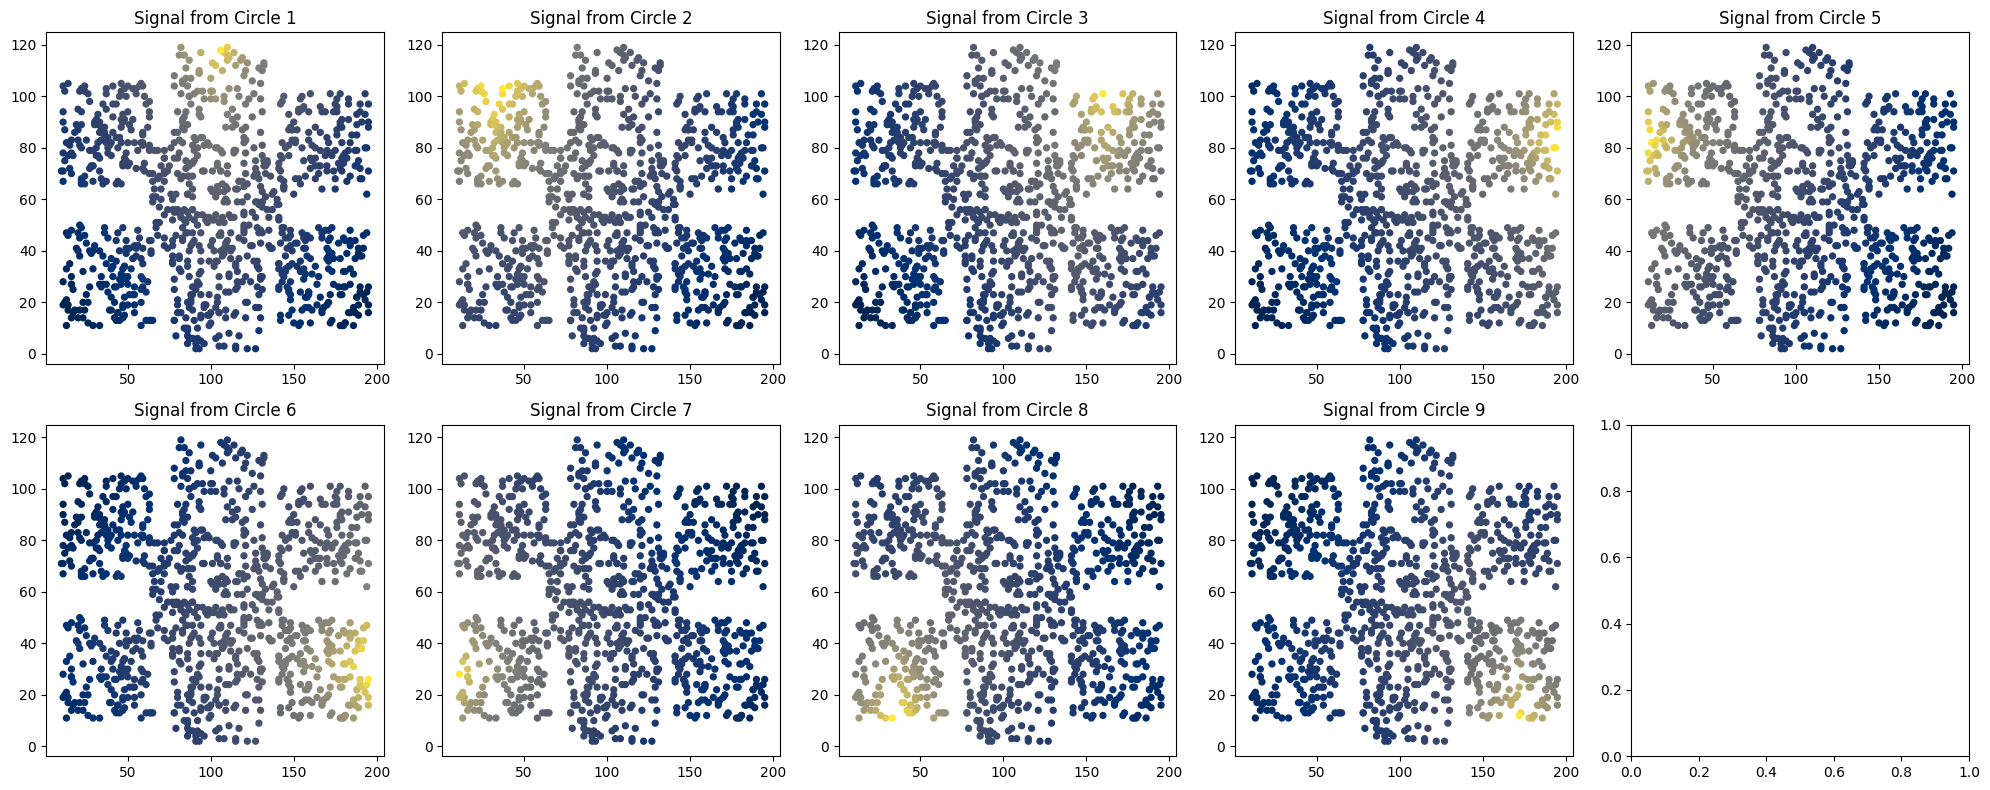

In [112]:
labeled_indices = [i for i in range(20)]
signal_graph = SignalGraph(signals, embedding_dim=EIG_V_DIM, k_nearest=7)
# Get the random points from the area_graph object
random_points_from_A = area_graph.get_points()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()[:9]):
    ax.scatter(random_points_from_A[:, 0], random_points_from_A[:, 1],
               c=np.log(1 / (area_graph.dist_matrix[:, i]**2)), s=18, cmap='cividis')
    ax.set_title(f'Signal from Circle {i+1}')

plt.tight_layout()
plt.show()

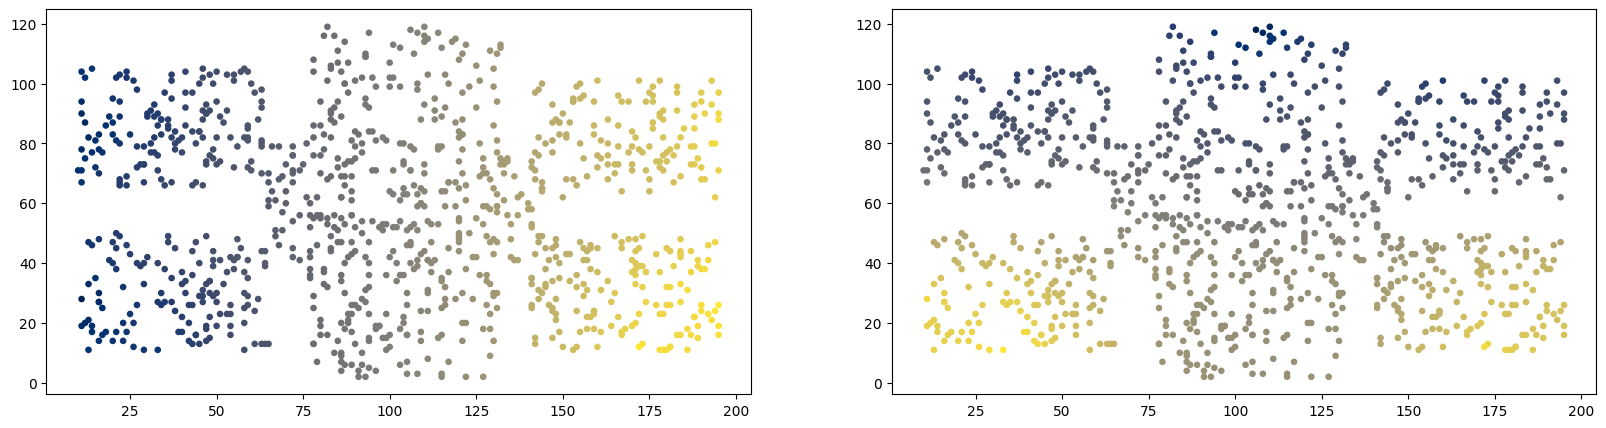

In [113]:
fig,axs = plt.subplots(1,EIG_V_DIM,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points_from_A[:,0],random_points_from_A[:,1],c = signal_graph.embedding[:,i],s = 14,cmap = 'cividis')

In [114]:
area_graph._compute_embedding()

5


# SSL RUN

In [67]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)

# Define labeled indices
labeled_indices = [i for i in range(50)] # Use the first 20 points for fitting

# Initialize and fit the matcher using the pre-built graphs and labeled indices
matcher = MatcherSSL()
phi_s, centered_A, C, calib_phi_s = matcher.fit(area_graph, signal_graph, labeled_indices)
calib_phi_s
phi_s.shape

phi_S_dim :(50, 2), A_dim:(50, 2), C dim (2, 2), 
[[1582.82925699  -24.34234333]
 [ -45.43476872 -874.60836859]]


(50, 2)

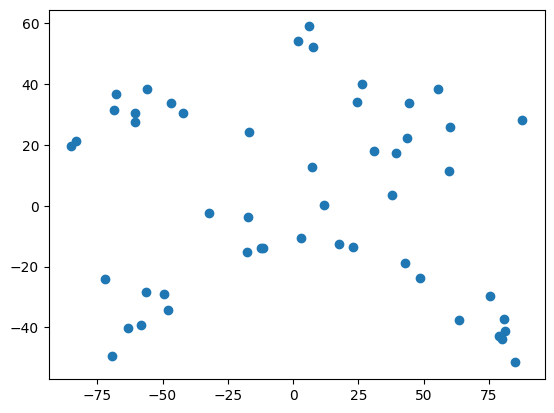

In [68]:
plt.scatter(phi_s @ C[:,0], phi_s @ C[:,1]) 


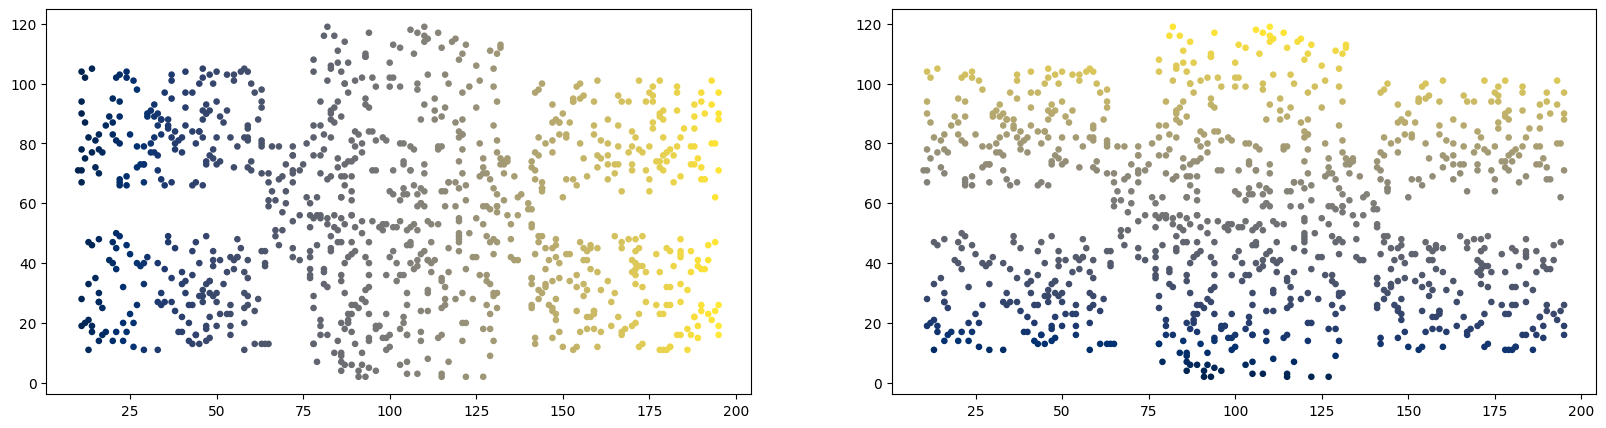

In [69]:
# EIGHEN VECTORS AREA
fig,axs = plt.subplots(1,EIG_V_DIM,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points_from_A[:,0],random_points_from_A[:,1],c = area_graph.embedding[:,i],s = 14,cmap = 'cividis')

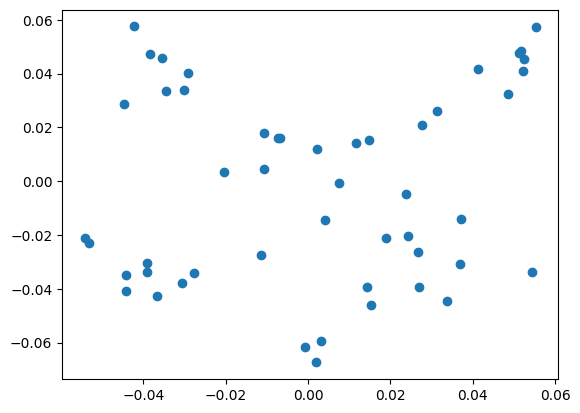

In [71]:
plt.scatter(phi_s[:,0], phi_s[:,1]) 


In [72]:
# Define validation indices (e.g., indices from 20 to 29)
# Make sure these indices are not in labeled_indices
validation_indices = list(range(100, 150))

# Important: Add a check to ensure validation_indices do not overlap with labeled_indices
if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values
validation_signal_data.shape
# Predict locations for the validation signal data
predicted_locations_validation = matcher.predict(validation_signal_data, validation_indices)


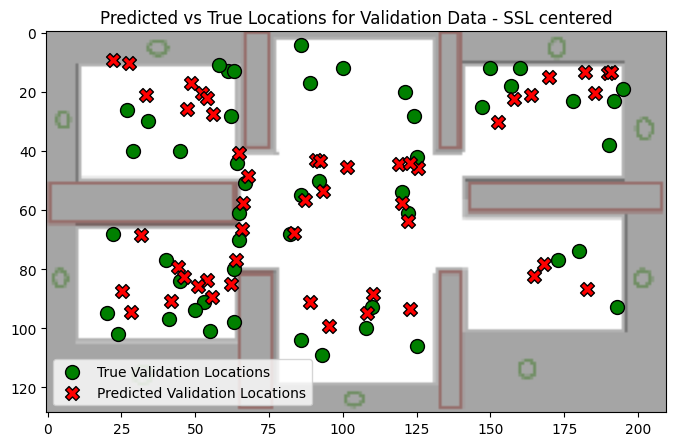

In [73]:
# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_validation[:, 0], predicted_locations_validation[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data - SSL centered")
plt.show()

# Manifold Matching

In [115]:
class ManifoldMatcher:
    def __init__(self, layout_graph= None, signal_graph = None):
        self.fitted = False
        self.layout_graph = layout_graph
        self.signal_graph = signal_graph
        self.aligned_signal_embedding = None
        self.labeled_indices = None 

    def fit(self, labeled_indices):
        """
        Calibrate layout to signal space using SSL-style least squares.
        """
        self.layout_embedding = layout_graph.embedding
        self.signal_embedding = signal_graph.embedding

        # phi_A = layout_embedding[labeled_indices]
        phi_S = self.signal_embedding[labeled_indices]
        phi_A = self.layout_embedding[labeled_indices]
        print(f"phi_S_dim :{phi_S.shape}, A_emb_dim:{self.layout_embedding[labeled_indices].shape}, ")
        self.C, _, _, _ = np.linalg.lstsq( phi_S, phi_A, rcond=None)
       
        print(self.C.shape)
        
        self.calibrated_phi_s = phi_S  @ self.C
        self.fitted = True
        return phi_S, centered_A, self.C, self.calibrated_phi_s

    def predict(self, new_signal_vectors, validation_indices):
        """
        Predict layout locations for new signal vectors (not embeddings).
        Uses 1-NN matching in calibrated spectral space.
        """
        if not self.fitted:
            raise ValueError("Must call .fit() before .predict()")
        # self.calibrated_phi_s = self.calibrated_phi_s + self.A_mean
        
        self.calibrated_phi_s = self.signal_embedding[validation_indices] @ self.C
        self.calibrated_all_points_phi_s = self.signal_embedding @ self.C
        D = cdist(self.calibrated_phi_s, self.layout_embedding)
        min_idx = np.argmin(D, axis=1)
        return self.layout_graph.get_points()[min_idx]


In [116]:
manifold = ManifoldMatcher(area_graph, signal_graph)

In [117]:
manifold.fit(labeled_indices)

phi_S_dim :(20, 2), A_emb_dim:(20, 4), 
(2, 4)


(array([[ 0.00747298, -0.00064298],
        [-0.02916987,  0.04008663],
        [ 0.03694575, -0.03072567],
        [ 0.01492378,  0.01524878],
        [ 0.05124649,  0.04751239],
        [ 0.02370068, -0.0046841 ],
        [-0.03019365,  0.03388832],
        [ 0.03365444, -0.0446194 ],
        [ 0.00229217,  0.01213511],
        [ 0.01437031, -0.03940297],
        [-0.02030243,  0.00336319],
        [ 0.02768762,  0.02089864],
        [-0.00065206, -0.0618055 ],
        [-0.00682309,  0.01593802],
        [-0.03664136, -0.04273834],
        [-0.05307397, -0.02293064],
        [ 0.00308297, -0.0596075 ],
        [ 0.03720468, -0.01424016],
        [-0.04430635, -0.03470713],
        [-0.03544906,  0.04565556]]),
 array([[ 11.445,  -4.118],
        [-38.555, -44.118],
        [ 66.445,  19.882],
        [ 26.445, -39.118],
        [ 74.445, -31.118],
        [ 37.445,   2.882],
        [-49.555, -20.118],
        [ 53.445,  38.882],
        [  2.445, -27.118],
        [ 27.445,  47.882]

In [118]:
manifold.calibrated_phi_s.shape

(20, 4)

In [119]:
# Define validation indices (e.g., indices from 20 to 29)
# Make sure these indices are not in labeled_indices
validation_indices = list(range(100, 150))

# Important: Add a check to ensure validation_indices do not overlap with labeled_indices
if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values
validation_signal_data.shape
# Predict locations for the validation signal data
predicted_locations_validation_manifold = manifold.predict(validation_signal_data, validation_indices)


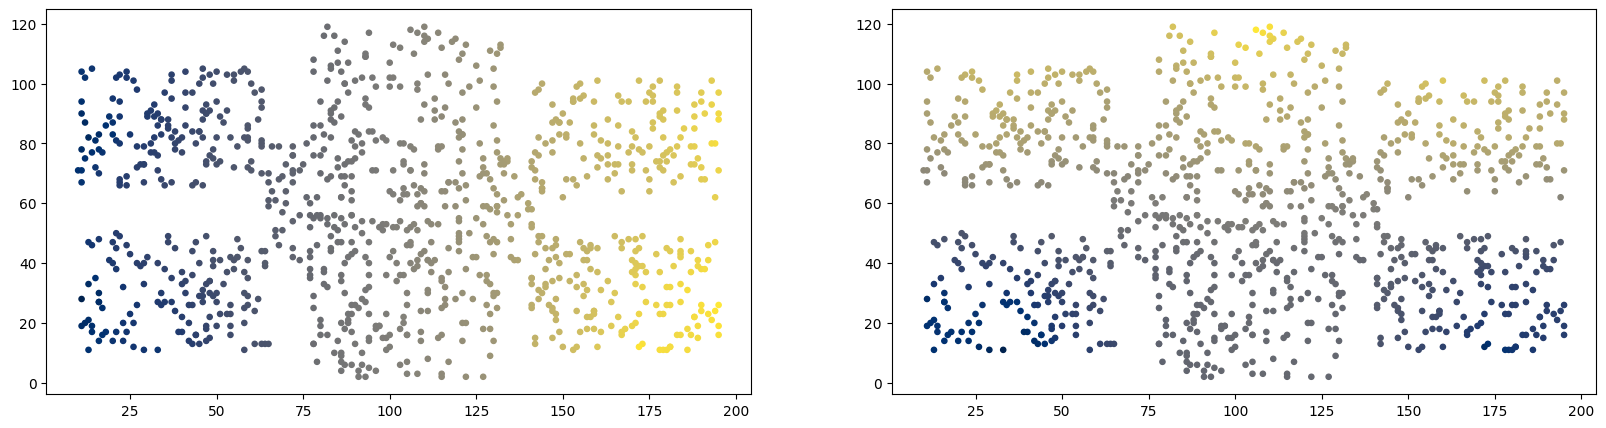

In [120]:
# EIGHEN VECTORS phi s @ C
fig,axs = plt.subplots(1,EIG_V_DIM,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points_from_A[:,0],random_points_from_A[:,1],c = manifold.calibrated_all_points_phi_s[:,i],s = 14,cmap = 'cividis')

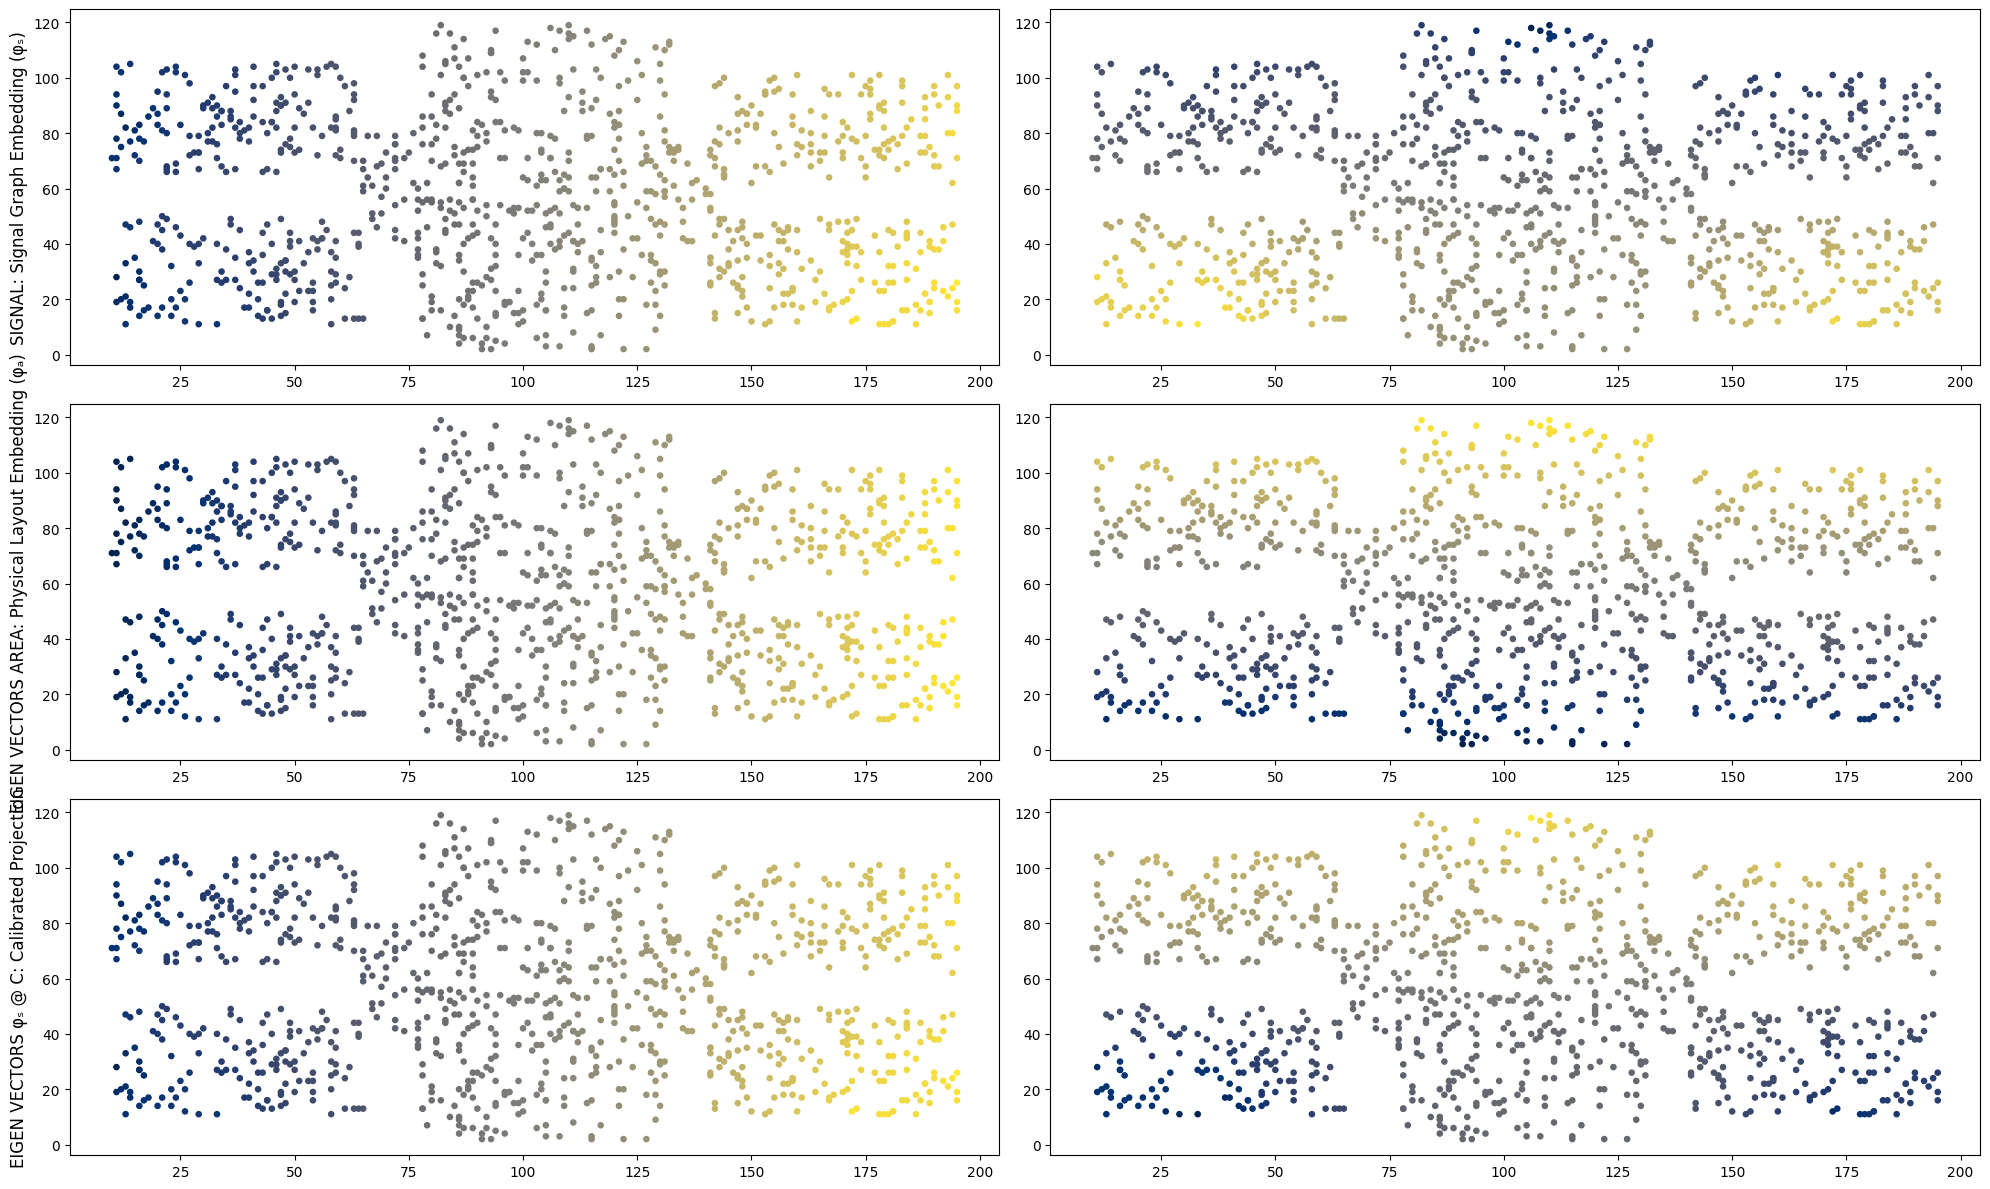

In [121]:
fig, axs = plt.subplots(3, EIG_V_DIM, figsize=(20, 12))

# Row titles
row_titles = [
    "SIGNAL: Signal Graph Embedding (φₛ)",
    "EIGEN VECTORS AREA: Physical Layout Embedding (φₐ)",
    "EIGEN VECTORS φₛ @ C: Calibrated Projection"
]

# Plot row 1: Signal graph
for i, ax in enumerate(axs[0]):
    ax.scatter(random_points_from_A[:, 0], random_points_from_A[:, 1],
               c=signal_graph.embedding[:, i], s=14, cmap='cividis')
    if i == 0:
        ax.set_ylabel(row_titles[0], fontsize=12)

# Plot row 2: Area graph
for i, ax in enumerate(axs[1]):
    ax.scatter(random_points_from_A[:, 0], random_points_from_A[:, 1],
               c=area_graph.get_embedding()[:, i], s=14, cmap='cividis')
    if i == 0:
        ax.set_ylabel(row_titles[1], fontsize=12)

# Plot row 3: Calibrated projection
for i, ax in enumerate(axs[2]):
    ax.scatter(random_points_from_A[:, 0], random_points_from_A[:, 1],
               c=manifold.calibrated_all_points_phi_s[:, i], s=14, cmap='cividis')
    if i == 0:
        ax.set_ylabel(row_titles[2], fontsize=12)

plt.tight_layout()
plt.show()


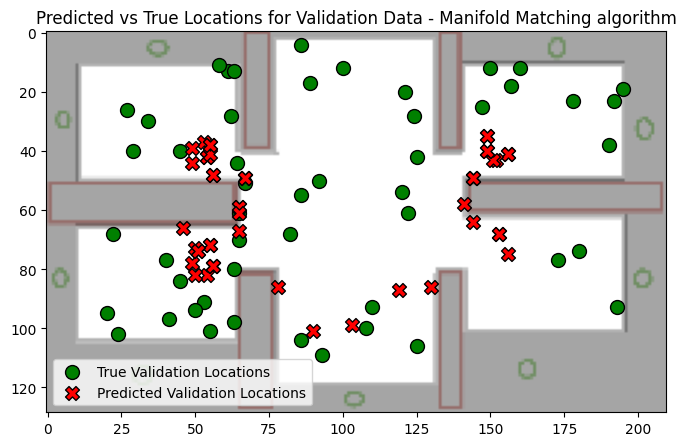

In [122]:
# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_validation_manifold[:, 0], predicted_locations_validation_manifold[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data - Manifold Matching algorithm")
plt.show()

In [124]:
# IMPLEMENT CROSS VALIDATION

# MEASURE THE FAULT and plot it

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Initialize area and signal graphs
area_graph = PhysicalLayoutGraph("your_image.png")  # Replace with actual image path
signal_data = np.random.rand(1000, 3)  # Replace with your signal data
signal_graph = SignalGraph(signal_data, embedding_dim=4, k_nearest=5)

# Create labeled and test indices
all_indices = list(range(len(area_graph.get_points())))
train_indices, test_indices = train_test_split(all_indices, test_size=0.3, random_state=42)

# Run ManifoldMatcherSSL
matcher = MatcherSSL()
phi_s, centered_A, C, calib_phi_s = matcher.fit(area_graph, signal_graph, train_indices)

# Predict
new_signal_vectors = signal_graph.get_embedding()[test_indices]
predicted_locations = matcher.predict(new_signal_vectors, test_indices)

# Evaluate
true_locations = np.array(area_graph.get_points())[test_indices]
mse = mean_squared_error(true_locations, predicted_locations)
print("Mean Squared Error for SSL prediction:", mse)

# Plot
area_graph.plot_on_layout(predicted_locations, true_locations, title="Predicted vs True Locations")


# Cross Validation

In [ ]:
def run_loocv(layout_graph, signal_graph, shared_indices, l_dims, s_dims):
    """
    Perform Leave-One-Out Cross Validation for different embedding dimensions.
    
    Arguments:
    - layout_graph: Physical layout graph (e.g. G^A)
    - signal_graph: Signal graph (e.g. G^S)
    - shared_indices: indices where both layout and signal are available
    - l_dims: list of layout embedding dimensions (e.g. [2, 3, 4])
    - s_dims: list of signal embedding dimensions (e.g. [2, 3, 4])
    
    Returns:
    - cv_errors: 2D array of average errors for each (l_dim, s_dim)
    - l_dims: layout embedding dimensions
    - s_dims: signal embedding dimensions
    """
    num_points = len(shared_indices)
    layout_embedding_full = layout_graph.get_embedding()
    signal_embedding_full = signal_graph.get_embedding()
    layout_points = np.array(layout_graph.get_points())

    cv_errors = np.zeros((len(l_dims), len(s_dims)))

    for i, l_dim in enumerate(l_dims):
        for j, s_dim in enumerate(s_dims):
            errors = []

            for held_out_idx in range(num_points):
                train_idx = shared_indices[:held_out_idx] + shared_indices[held_out_idx+1:]
                test_idx = shared_indices[held_out_idx]

                phi_A = layout_embedding_full[train_idx, :l_dim]
                phi_S = signal_embedding_full[train_idx, :s_dim]

                A_all = layout_points
                A_mean = A_all.mean(axis=0, keepdims=True)
                centered_A = A_all[train_idx] - A_mean

                # Solve least squares regression phi_S → A
                C, _, _, _ = np.linalg.lstsq(phi_S, centered_A, rcond=None)

                # Predict for held-out signal
                phi_S_test = signal_embedding_full[test_idx, :s_dim]
                pred = phi_S_test @ C + A_mean
                true = layout_points[test_idx]

                error = np.linalg.norm(pred - true)
                errors.append(error)

            cv_errors[i, j] = np.mean(errors)

    return cv_errors, l_dims, s_dims


In [ ]:
l_dims = [2, 4, 6, 8, 10]  # Layout embedding dimensions to try
s_dims = [2, 4, 6, 8, 10]  # Signal embedding dimensions to try

cv_errors, l_vals, s_vals = run_loocv(layout_graph, signal_graph, shared_indices, l_dims, s_dims)